# TarDiff - génération ciblée par influence 

Ce notebook est mon implémentation personnelle de l’article [TarDiff: Target-Oriented Diffusion Guidance for Synthetic Electronic Health Record Time Series Generation](https://arxiv.org/abs/2504.17613) de Bowen Deng et al., 2023 dans le cadre de mon cours de simulation et modèles génératifs enseigné par Sylvain Le Corff. 

Le but est de maitriser en profondeur l'article en l'implémentant sur un jeu de données simple (2D) avant de l'appliquer sur un jeu de données réel (ECG) et de challenger la performance / pertinence des différents choix d'implémentations et d'hyperparamètres.  

## 1. Introduction

### Contexte et objectif

Les modèles de diffusion permettent de générer des séries temporelles médicales synthétiques (EHR), utiles pour pallier la rareté des données et les contraintes de confidentialité.  
Cependant, la plupart des approches existantes optimisent uniquement le **réalisme** des données générées, sans se soucier de leur **utilité pour les tâches cliniques downstream** (ex. prédiction de mortalité ou d’admission en réanimation).

Résultat : les données synthétiques reproduisent surtout des trajectoires fréquentes, et apportent peu d’information pour les cas rares mais cliniquement critiques.

Or, en pratique clinique, les données sont fortement **déséquilibrées** : la majorité des patients ne présentent pas l’événement d’intérêt (ex. décès, admission en réanimation, complications sévères...). C'est une bonne nouvelle :), mais les modèles génératifs tendent alors à sur-représenter des trajectoires fréquentes. 

Donc il est crucial de générer des données synthétiques qui soient non seulement réalistes, mais aussi **utiles** pour les tâches cliniques spécifiques.

### Idée clé de TarDiff

**TarDiff** (Target-Oriented Diffusion) propose de guider la génération de données synthétiques en fonction de leur impact sur une tâche cible.

Pour cela :
- on mesure, via des **fonctions d’influence**, l’effet qu’un échantillon synthétique aurait sur les performances d’un modèle prédictif donné,
- ces scores d’influence sont utilisés comme signal de guidage dans le processus inverse de diffusion.

La génération est ainsi orientée vers des échantillons qui sont :
- plausibles d’un point de vue médical,
- explicitement bénéfiques pour la tâche clinique considérée.

### Plan du notebook

1. Introduction
2. Présentation formelle de la méthode TarDiff
3. Implémentation de TarDiff sur un jeu de données 2D simple
4. Analyse de la méthode sur un jeu simple biaisé
5. Application à des données ECG réelles 
6. Discussion et perspectives

## 2. Présentation formelle de la méthode TarDiff

L'idée centrale de TarDiff est de transformer un problème de génération (imiter la distribution des données) en un problème de génération orientée tâche : on guide la diffusion pour produire des exemples synthétiques qui, s'ils étaient ajoutés au train, amélioreraient la performance d'un modèle downstream sur des données i.i.d. non vues.

### 2.1 Influence : mesurer l'utilité d'un point synthétique pour une tâche

On fixe une tâche downstream $T$ avec une loss $\ell_T(\cdot;\phi)$ et un modèle $f_\phi$. Sur le dataset d'entraînement

$$
\mathcal{D}_{\text{train}}=\{(x_i,y_i)\}_{i=1}^n,
$$

on définit les paramètres optimaux :

$$
\phi^*=\arg\min_\phi \sum_{(x_i,y_i)\in \mathcal{D}_{\text{train}}}\ell_T(x_i,y_i;\phi).
$$

On considère ensuite un échantillon synthétique candidat $\hat{z}=(x,y)$ que l'on ajouterait au train. Le nouvel optimum devient :

$$
\phi^{\hat{z}}=\arg\min_\phi \sum_{(x_i,y_i)\in \mathcal{D}_{\text{train}}\cup\{\hat{z}\}}\ell_T(x_i,y_i;\phi).
$$

Pour une donnée de test $(x',y')$, on regarde le changement de loss induit par l'ajout de $\hat{z}$ :

$$
H(x,y,x',y')=\ell_T(x',y';\phi^{\hat{z}})-\ell_T(x',y';\phi^*).
$$

Si $P$ désigne la distribution i.i.d. des données futures, l'influence est l'amélioration attendue sur cette distribution :

$$
\Delta L_T(\hat{z})\;:=\;
-\mathbb{E}_{(x',y')\sim P}\big[\ell_T(x',y';\phi^{\hat{z}})-\ell_T(x',y';\phi^*)\big].
$$

Objectif conceptuel :

$$
\hat{z}^*=\arg\max_{\hat{z}}\Delta L_T(\hat{z}),
$$

c'est-à-dire générer des points qui maximisent le gain attendu en généralisation.

**Intuition.** On ne veut pas seulement ressembler aux données. On veut des points qui, une fois ajoutés au train, font baisser la loss sur des exemples i.i.d. représentatifs, en pratique approximés par un split de validation servant de guidance set.

### 2.2 Du critère d'influence au guidage de la diffusion


On part d'un modèle de diffusion conditionnel par $y$. À l'étape $t$ du reverse process, le DDPM définit :

$$
p_\theta(x_{t-1}\mid x_t,y)
=\mathcal{N}\big(\mu_\theta(x_t,y,t),\Sigma_\theta(t)\big).
$$

Principe général du *guidage* en diffusion : au lieu d'échantillonner autour de la moyenne $\mu_\theta$ telle quelle, on la **décale légèrement** dans une direction qui augmente un critère d'intérêt $S(x_t,y)$. Comme l'échantillonnage est gaussien, ce décalage suffit à **biaiser la trajectoire de débruitage** vers des régions de l'espace où ce critère est plus élevé.

TarDiff applique ce principe avec un critère orienté tâche. Ici, le critère n'est pas une probabilité de classe, mais l'influence $\Delta L_T(\hat z)$, qui mesure à quel point un point synthétique $\hat z=(x,y)$ améliorerait la performance du modèle downstream sur des données i.i.d. À l'étape $t$, on interprète $\hat z_t=(x_t,y)$ comme un prototype de l'échantillon final, et on guide la diffusion vers les régions où cette influence est grande en ajoutant son gradient à la moyenne :

$$
\tilde{\mu}_t
=\mu_\theta(x_t,y,t)+w\,\nabla_{x_t}\Delta L_T(\hat{z}_t),
\qquad \hat{z}_t=(x_t,y),
$$

puis on échantillonne :

$$
x_{t-1}\sim \mathcal{N}\big(\tilde{\mu}_t,\Sigma_\theta(t)\big).
$$

Ainsi, $\nabla_{x_t}\Delta L_T(\hat z_t)$ indique la direction qui augmente le plus l'utilité attendue du futur échantillon pour la tâche, tandis que $w$ contrôle l'intensité de ce biais par rapport au débruitage standard.

### 2.3 Estimation pratique : cache de gradients et terme de guidage


Calculer exactement $\Delta L_T(\hat{z})$ est intractable car il faudrait réentraîner $f_\phi$ pour chaque $\hat{z}$. TarDiff utilise une approximation de type influence function : l'effet d'ajouter $\hat{z}$ sur la loss d'un point $(x_g,y_g)$ dépend de l'alignement de leurs gradients.

On introduit un guidance set

$$
\mathcal{D}_{\text{guide}}=\{(x_g,y_g)\}_{g=1}^N,
$$

supposé i.i.d. de $P$. On agrège une fois pour toutes les gradients du downstream entraîné :

$$
G \;\triangleq\;
\frac{1}{|\mathcal{D}_{\text{guide}}|}
\sum_{(x_g,y_g)\in \mathcal{D}_{\text{guide}}}
\nabla_\phi \ell_T(x_g,y_g;\phi^*).
$$

À des constantes de normalisation et de signe près, l'influence d'un candidat $\hat{z}$ est alors :

$$
\Delta L_T(\hat{z})\approx
\nabla_\phi \ell_T(x,y;\phi^*)\cdot G.
$$

Le signal de guidage au temps $t$ devient :

$$
J_t
\;\triangleq\;
\nabla_{x_t}\Big(
\nabla_\phi \ell_T(x_t,y;\phi^*)\cdot G
\Big).
$$

### 2.4 Algorithme (pipeline TarDiff)

1. **Pré-entraîner le modèle downstream**

$$
\phi^*=\arg\min_\phi
\sum_{(x,y)\in \mathcal{D}_{\text{train}}}
\ell_T(x,y;\phi).
$$

2. **Calculer le cache de gradients**

$$
G \leftarrow
\frac{1}{|\mathcal{D}_{\text{guide}}|}
\sum_{(x_g,y_g)\in \mathcal{D}_{\text{guide}}}
\nabla_\phi \ell_T(x_g,y_g;\phi^*).
$$

3. **Sampling par diffusion guidée**

   Initialiser $x_T\sim\mathcal{N}(0,I)$.  
   Pour $t=T,\dots,1$ :
   
   $$
   \mu_t \leftarrow \mu_\theta(x_t,y,t),
   $$
   
   $$
   J_t \leftarrow
   \nabla_{x_t}\Big(
   \nabla_\phi \ell_T(x_t,y;\phi^*)\cdot G
   \Big),
   $$
   
   $$
   \tilde{\mu}_t \leftarrow \mu_t + w\,J_t,
   $$
   
   $$
   x_{t-1}\sim \mathcal{N}(\tilde{\mu}_t,\Sigma_\theta(t)).
   $$
   
   Retourner l'échantillon synthétique $\hat{z}=(x_0,y)$.


## 3. Données simulées : toy Gaussienne 2D

L’objectif de cette partie est de mettre en place un **cadre jouet contrôlé** pour valider le pipeline TarDiff sur un cas simple et interprétable.

### 3.1 Vue d'ensemble du protocole

- **Distribution** : mélange de deux gaussiennes 2D.
- **Labels** : $y \in \{0,1\}$ selon la composante.
- **Split** : train / val (guide) / test.
- **Tâche downstream** : classification binaire (Accuracy, AUROC, AUPRC).

Ici, on se limite au cas **équilibré (50/50)**.

### 3.2 Génération du dataset 

On génère un jeu de données de deux gaussiennes 2D équilibré et un **split train/guide/test**.

In [1]:
# --- Imports & config ---
import os
import math
import random
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score

# Reproductibilité
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [2]:
from sklearn.datasets import make_blobs
from torch.utils.data import TensorDataset, DataLoader

@dataclass
class ToyConfig:
    n_samples: int = 10000
    minority_ratio: float = 0.5
    batch_size: int = 128
    test_samples: int = 2000


def make_toy_gaussians(cfg: ToyConfig):
    n_min = int(cfg.n_samples * cfg.minority_ratio)
    n_maj = cfg.n_samples - n_min

    X_maj, y_maj = make_blobs(n_samples=n_maj, centers=[[0.0, 0.0]], cluster_std=1)
    X_min, y_min = make_blobs(n_samples=n_min, centers=[[2.0, 2.0]], cluster_std=1)
    y_maj[:] = 0
    y_min[:] = 1

    X = np.vstack([X_maj, X_min])
    y = np.hstack([y_maj, y_min])

    # global normalization
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X = (X - mean) / std

    # Shuffle
    idx = np.random.permutation(len(X))
    X, y = X[idx], y[idx]

    X = torch.tensor(X, dtype=torch.float32).to(DEVICE)
    y = torch.tensor(y, dtype=torch.long).to(DEVICE)

    # Split train/guide
    n_train = int(0.8 * len(X))
    X_train, y_train = X[:n_train], y[:n_train]
    X_guide, y_guide = X[n_train:], y[n_train:]

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=cfg.batch_size, shuffle=True)
    guide_loader = DataLoader(TensorDataset(X_guide, y_guide), batch_size=len(X_guide), shuffle=False)

    # Test set (balanced)
    X_maj_t, y_maj_t = make_blobs(n_samples=cfg.test_samples // 2, centers=[[-2.0, -2.0]], cluster_std=0.8)
    X_min_t, y_min_t = make_blobs(n_samples=cfg.test_samples // 2, centers=[[2.5, 2.5]], cluster_std=0.8)
    y_maj_t[:] = 0
    y_min_t[:] = 1
    X_test = np.vstack([X_maj_t, X_min_t])
    y_test = np.hstack([y_maj_t, y_min_t])
    X_test = (X_test - mean) / std

    X_test = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
    y_test = torch.tensor(y_test, dtype=torch.long).to(DEVICE)

    stats = dict(mean=mean, std=std)
    return train_loader, guide_loader, (X_train, y_train), (X_test, y_test), stats

cfg = ToyConfig(minority_ratio=0.5)
train_loader, guide_loader, (X_train, y_train), (X_test, y_test), stats = make_toy_gaussians(cfg)
print("Train size:", X_train.shape, "Guide size:", next(iter(guide_loader))[0].shape)
print("Test size:", X_test.shape)

Train size: torch.Size([8000, 2]) Guide size: torch.Size([2000, 2])
Test size: torch.Size([2000, 2])


On vérifie que la distribution simulée est bien formée et équilibrée avant d’entraîner les modèles.

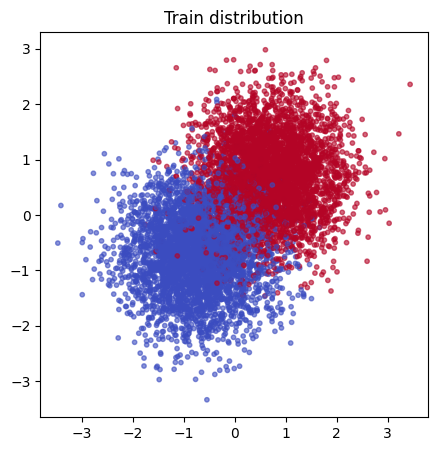

In [3]:
# Quick visual sanity check
plt.figure(figsize=(5, 5))
plt.scatter(X_train[:, 0].cpu(), X_train[:, 1].cpu(), c=y_train.cpu(), s=10, cmap='coolwarm', alpha=0.6)
plt.title("Train distribution")
plt.show()

Notons que l'on choisit des centres pas trop éloignés pour que la tâche de classification soit non triviale et on verra que ca illustre bien l'intérêt de TarDiff.

### 3.3 Entraînement des modèles

D'après le pipeline TarDiff, il faut entraîner le **modèle downstream** pour pouvoir calculer le cache de gradients. Et le **modèle de diffusion** conditionnelle est aussi supposé entraîné sur le train.

C'est ce que l'on va faire dans cette section.

#### 3.3.1 Modèles et configurations

On définit d’abord les architectures minimales et les hyperparamètres d'entraînement.

In [4]:
# models 
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=8, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.net(x)


class SimpleDiffusionNet(nn.Module):
    def __init__(self, t_dim=16):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(1, t_dim),
            nn.SiLU(),
            nn.Linear(t_dim, t_dim)
        )
        self.net = nn.Sequential(
            nn.Linear(2 + t_dim + 1, 64),
            nn.SiLU(),
            nn.Linear(64, 64),
            nn.SiLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x, t, y):
        t_emb = self.time_mlp(t.float())
        y_emb = y.view(-1, 1).float()
        x_in = torch.cat([x, t_emb, y_emb], dim=1)
        return self.net(x_in)


class DDPMScheduler:
    def __init__(self, num_timesteps=50, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.beta = torch.linspace(1e-4, 0.02, num_timesteps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_hat = torch.sqrt(self.alpha_hat)
        self.sqrt_one_minus_alpha_hat = torch.sqrt(1.0 - self.alpha_hat)

    def noise(self, x, t):
        sqrt_alpha_hat = self.sqrt_alpha_hat[t].view(-1, 1)
        sqrt_one_minus_alpha_hat = self.sqrt_one_minus_alpha_hat[t].view(-1, 1)
        eps = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * eps, eps

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.num_timesteps, size=(n,)).to(self.device)


#### 3.3.2 Entraînement 

On entraîne d'abord le classifieur, puis le modèle de diffusion conditionnelle.

Commencons par définir les fonctions d'entraînement et d'évaluation pour les deux modèles.

In [5]:
# Training utils

@dataclass
class TrainConfig:
    clf_epochs: int = 30
    diff_epochs: int = 50
    clf_lr: float = 1e-3
    diff_lr: float = 1e-3
    timesteps: int = 50


def train_classifier(model, loader, cfg: TrainConfig):
    model.train()
    opt = optim.Adam(model.parameters(), lr=cfg.clf_lr)
    crit = nn.CrossEntropyLoss()
    for _ in range(cfg.clf_epochs):
        for x, y in loader:
            opt.zero_grad()
            loss = crit(model(x), y)
            loss.backward()
            opt.step()


def train_diffusion(model, loader, scheduler: DDPMScheduler, cfg: TrainConfig):
    model.train()
    opt = optim.Adam(model.parameters(), lr=cfg.diff_lr)
    crit = nn.MSELoss()
    for _ in range(cfg.diff_epochs):
        for x, y in loader:
            opt.zero_grad()
            t = scheduler.sample_timesteps(x.shape[0]).view(-1, 1)
            x_t, noise = scheduler.noise(x, t)
            noise_pred = model(x_t, t, y)
            loss = crit(noise_pred, noise)
            loss.backward()
            opt.step()


def eval_classifier(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)
    acc = accuracy_score(y.cpu().numpy(), preds.cpu().numpy())
    auroc = roc_auc_score(y.cpu().numpy(), probs.cpu().numpy())
    auprc = average_precision_score(y.cpu().numpy(), probs.cpu().numpy())
    return dict(acc=acc, auroc=auroc, auprc=auprc)


cfg_train = TrainConfig()
scheduler = DDPMScheduler(num_timesteps=cfg_train.timesteps, device=DEVICE)

Maintenant, on peut entraîner le classifieur downstream.

In [6]:
cfg_train_bal = TrainConfig()

clf_bal = SimpleClassifier().to(DEVICE)
train_classifier(clf_bal, train_loader, cfg_train_bal)
metrics_real_bal = eval_classifier(clf_bal, X_test, y_test)
print("Downstream on real :", metrics_real_bal)

Downstream on real : {'acc': 0.9975, 'auroc': 1.0, 'auprc': 1.0}


Evidément, les performances sont très bonnes sur ce cas simple. 

Entraînons ensuite le modèle de diffusion conditionnelle sur le train.

In [7]:
# --- Training (Balanced 50/50) ---
scheduler_bal = DDPMScheduler(num_timesteps=cfg_train_bal.timesteps, device=DEVICE)

diff_model_bal = SimpleDiffusionNet().to(DEVICE)
train_diffusion(diff_model_bal, train_loader, scheduler_bal, cfg_train_bal)
print("Diffusion trained (balanced).")

Diffusion trained (balanced).


On vérifie que le DDPM conditionnel apprend correctement $p(x|y)$ sur le cas équilibré.

In [8]:
from scipy.stats import wasserstein_distance

def sample_standard(model, scheduler, n_samples, c):
    """Génération standard sans guidage (w=0) pour validation."""
    model.eval()
    with torch.no_grad():
        x = torch.randn((n_samples, 2)).to(DEVICE)
        y = torch.full((n_samples,), c, dtype=torch.long).to(DEVICE)
        
        for i in reversed(range(1, scheduler.num_timesteps)):
            t = (torch.ones(n_samples) * i).long().to(DEVICE).view(-1, 1)
            noise_pred = model(x, t, y)
            
            alpha = scheduler.alpha[i]
            alpha_hat = scheduler.alpha_hat[i]
            beta = scheduler.beta[i]
            
            noise = torch.randn_like(x) if i > 1 else torch.zeros_like(x)
            x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * noise_pred) + torch.sqrt(beta) * noise
    return x


def check_distribution_metrics(real_samples, fake_samples, name=""):
    print(f"--- Check Distribution: {name} ---")
    
    mu_dist = torch.norm(real_samples.mean(dim=0) - fake_samples.mean(dim=0)).item()
    std_dist = torch.norm(real_samples.std(dim=0) - fake_samples.std(dim=0)).item()
    print(f"Diff Mean (L2): {mu_dist:.4f}")
    print(f"Diff Std  (L2): {std_dist:.4f}")
    
    wd0 = wasserstein_distance(real_samples[:,0].cpu().numpy(), fake_samples[:,0].cpu().numpy())
    wd1 = wasserstein_distance(real_samples[:,1].cpu().numpy(), fake_samples[:,1].cpu().numpy())
    print(f"Wasserstein Dist | Dim0: {wd0:.4f}, Dim1: {wd1:.4f}")
    
    return mu_dist, std_dist, wd0, wd1

Generating validation samples...
--- Check Distribution: Balanced Class 0 ---
Diff Mean (L2): 0.4215
Diff Std  (L2): 0.1407
Wasserstein Dist | Dim0: 0.2739, Dim1: 0.3205
--- Check Distribution: Balanced Class 1 ---
Diff Mean (L2): 0.5005
Diff Std  (L2): 0.1260
Wasserstein Dist | Dim0: 0.3501, Dim1: 0.3584


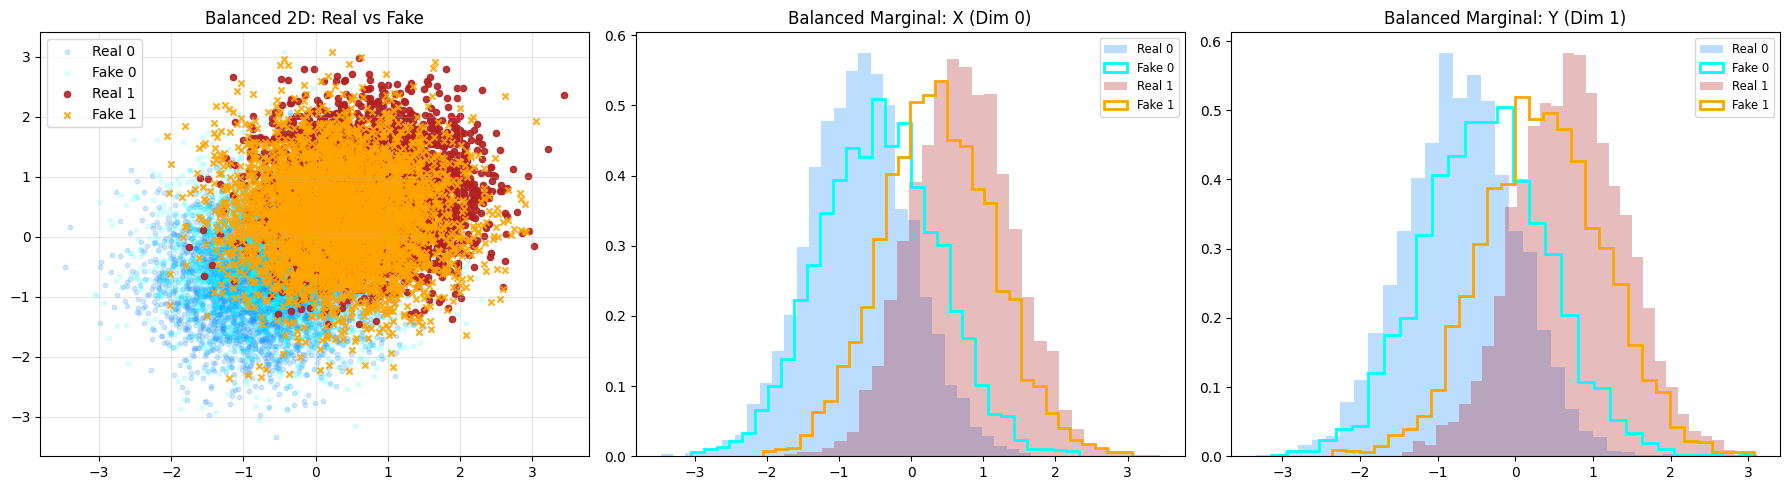

In [9]:
# --- Sanity Checks ---
print("Generating validation samples...")

X_maj_real_bal = X_train[y_train == 0]
X_maj_gen_bal = sample_standard(diff_model_bal, scheduler_bal, len(X_maj_real_bal), 0)

X_min_real_bal = X_train[y_train == 1]
X_min_gen_bal = sample_standard(diff_model_bal, scheduler_bal, len(X_min_real_bal), 1)

check_distribution_metrics(X_maj_real_bal, X_maj_gen_bal, "Balanced Class 0")
check_distribution_metrics(X_min_real_bal, X_min_gen_bal, "Balanced Class 1")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].set_title("Balanced 2D: Real vs Fake")
axes[0].scatter(X_maj_real_bal[:,0].cpu(), X_maj_real_bal[:,1].cpu(), alpha=0.2, label="Real 0", c='dodgerblue', s=10)
axes[0].scatter(X_maj_gen_bal[:,0].cpu(), X_maj_gen_bal[:,1].cpu(), alpha=0.2, label="Fake 0", c='cyan', s=10, marker='x')
axes[0].scatter(X_min_real_bal[:,0].cpu(), X_min_real_bal[:,1].cpu(), alpha=0.9, label="Real 1", c='firebrick', s=20)
axes[0].scatter(X_min_gen_bal[:,0].cpu(), X_min_gen_bal[:,1].cpu(), alpha=0.9, label="Fake 1", c='orange', s=20, marker='x')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for dim, ax, name in zip([0, 1], axes[1:], ["X (Dim 0)", "Y (Dim 1)"]):
    ax.set_title(f"Balanced Marginal: {name}")
    ax.hist(X_maj_real_bal[:, dim].cpu().numpy(), bins=30, density=True, alpha=0.3, color='dodgerblue', label='Real 0')
    ax.hist(X_maj_gen_bal[:, dim].cpu().numpy(), bins=30, density=True, histtype='step', linewidth=2, color='cyan', label='Fake 0')
    ax.hist(X_min_real_bal[:, dim].cpu().numpy(), bins=30, density=True, alpha=0.3, color='firebrick', label='Real 1')
    ax.hist(X_min_gen_bal[:, dim].cpu().numpy(), bins=30, density=True, histtype='step', linewidth=2, color='orange', label='Fake 1')
    ax.legend(fontsize='small')

plt.tight_layout()
plt.show()

On voit que les échantillons générés sont relativement bien distribués même si les densités synthétiques ont tendance à s'attirer un peu plus que les vraies.

### 3.4 Génération ciblée par influence

A ce stade, on a quasiment tout ce qu'il faut pour faire de la génération ciblée par influence :
- on a le classifieur entraîné,
- on a le modèle de diffusion entraîné,

Il nous reste à calculer le cache de gradients $G$ à partir du guide set avant de pouvoir faire de la génération influencée. 

#### 3.4.1 Cache de gradients

Là, on rentre dans la spécificité de TarDiff : on calcule le cache de gradients $G$ à partir du guide set.

Pour rappel :

$$
G \;=\; \frac{1}{|\mathcal{D}_{\text{guide}}|}\sum_{(x_g,y_g)\in \mathcal{D}_{\text{guide}}}\nabla_{\phi}\ell_T(x_g,y_g;\phi^*).
$$

En pratique, on **somme les gradients du classifieur** sur tout le guide set, puis on **normalise** ce vecteur global (L2). Ce cache sera ensuite utilisé dans le produit scalaire $\nabla_\phi \ell_T(x,y;\phi^*) \cdot G$ pour construire le terme de guidage.

In [10]:
# --- Influence Cache Computation ---

def _normalize_grads(grads, eps=1e-6):
    """L2 normalization across all parameter gradients (as in official code)."""
    total_norm = torch.sqrt(sum((g ** 2).sum() for g in grads))
    return [g / (total_norm + eps) for g in grads]

def compute_influence_cache(classifier, loader):
    classifier.eval()
    crit = nn.CrossEntropyLoss(reduction="sum")

    params = list(classifier.parameters())
    total_loss = torch.tensor(0.0, device=DEVICE)

    for x_g, y_g in loader:
        x_g, y_g = x_g.to(DEVICE), y_g.to(DEVICE)
        logits = classifier(x_g)
        total_loss += crit(logits, y_g)

    grads = torch.autograd.grad(total_loss, params, allow_unused=True) # compute gradients
    filtered = [(p, g) for p, g in zip(params, grads) if g is not None] # filter out None grads
    if not filtered:
        raise ValueError("No parameter received gradient!")

    filtered_params, filtered_grads = zip(*filtered) # unzip filtered parameters and gradients
    normed_grads = _normalize_grads(filtered_grads)

    G_cache = {
        name: g
        for (name, _), g in zip(classifier.named_parameters(), normed_grads) 
        if g is not None
    }
    return G_cache 


In [11]:
G_cache_bal = compute_influence_cache(clf_bal, guide_loader)
print("Influence cache norms :", {k: float(v.norm().item()) for k, v in G_cache_bal.items()})

Influence cache norms : {'net.0.weight': 0.26133158802986145, 'net.0.bias': 0.7117477655410767, 'net.2.weight': 0.4951535761356354, 'net.2.bias': 0.4241979718208313}


#### 3.4.2 Génération influencée

On a maintenant :
- le **modèle de diffusion conditionnel** entraîné,
- le **classifieur downstream**,
- le **cache de gradients $G$**.

On peut donc injecter le terme de guidage dans le reverse process pour obtenir une génération **orientée par l’influence**. Dans la suite, on implémente la fonction de sampling TarDiff qui ajoute $w\,J_t$ à la moyenne du DDPM.


In [12]:
# --- TarDiff Sampling ---

# This function implements guided DDPM sampling with an influence-based drift term.
# It follows the standard reverse diffusion loop and injects the TarDiff guidance J_t.

def tardiff_sample(model, scheduler, classifier, G_cache, n_samples=200, target_class=1, w=10.0):
    """
    J = grad_x [ <norm(grad_phi l(x,y)), norm(G)> ]
    """
    model.eval()
    classifier.eval()
    crit_clf = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        # Start from pure Gaussian noise and fix the target class.
        x = torch.randn((n_samples, 2)).to(DEVICE)
        y_cond = torch.full((n_samples,), target_class, dtype=torch.long).to(DEVICE)
        
        for i in reversed(range(1, scheduler.num_timesteps)):
            # Predict noise with the conditional diffusion model.
            t = (torch.ones(n_samples) * i).long().to(DEVICE).view(-1, 1)
            predicted_noise = model(x, t, y_cond)
            
            alpha = scheduler.alpha[i]
            alpha_hat = scheduler.alpha_hat[i]
            beta = scheduler.beta[i]
            
            # Compute the DDPM mean (x_recon) and the standard noise term.
            noise = torch.randn_like(x) if i > 1 else torch.zeros_like(x)
            x_recon = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * predicted_noise)
            
            # Compute the influence-guidance direction J_t (if w != 0).
            J = torch.zeros_like(x)
            if w != 0:  # Apply influence guidance
                with torch.enable_grad():
                    x_in = x.detach().clone()
                    x_in.requires_grad = True
                    
                    out_clf = classifier(x_in)
                    loss = crit_clf(out_clf, y_cond)
                    
                    grads_phi = torch.autograd.grad(loss, classifier.parameters(), create_graph=True, allow_unused=True)
                    filtered = [(p, g) for p, g in zip(classifier.parameters(), grads_phi) if g is not None]
                    if not filtered:
                        raise ValueError("No parameter received gradient!")
                    _, grads_phi = zip(*filtered)
                    grads_phi = _normalize_grads(grads_phi)
                    
                    # Influence score = dot product between per-sample grads and cached G.
                    influence_score = 0
                    for (name, _), g_phi in zip(classifier.named_parameters(), grads_phi):
                        if name in G_cache:
                            influence_score += torch.sum(g_phi * G_cache[name])  # dot product

                    # J_t is the gradient of the influence score w.r.t. x.
                    J = torch.autograd.grad(influence_score, x_in)[0]
                
                J = J.detach()
            
            # Final update: DDPM mean + guidance drift + noise.
            sigma_t = torch.sqrt(beta)
            x = x_recon + (w * J) + sigma_t * noise
            
    return x.detach()


Pour visualiser l'apport de la méthode, on va afficher les échantillons générés pour différentes valeurs de $w$, en les comparant aux vraies données d'entraînement pour les deux classes.

Sampling 1000 points per w (balanced)...


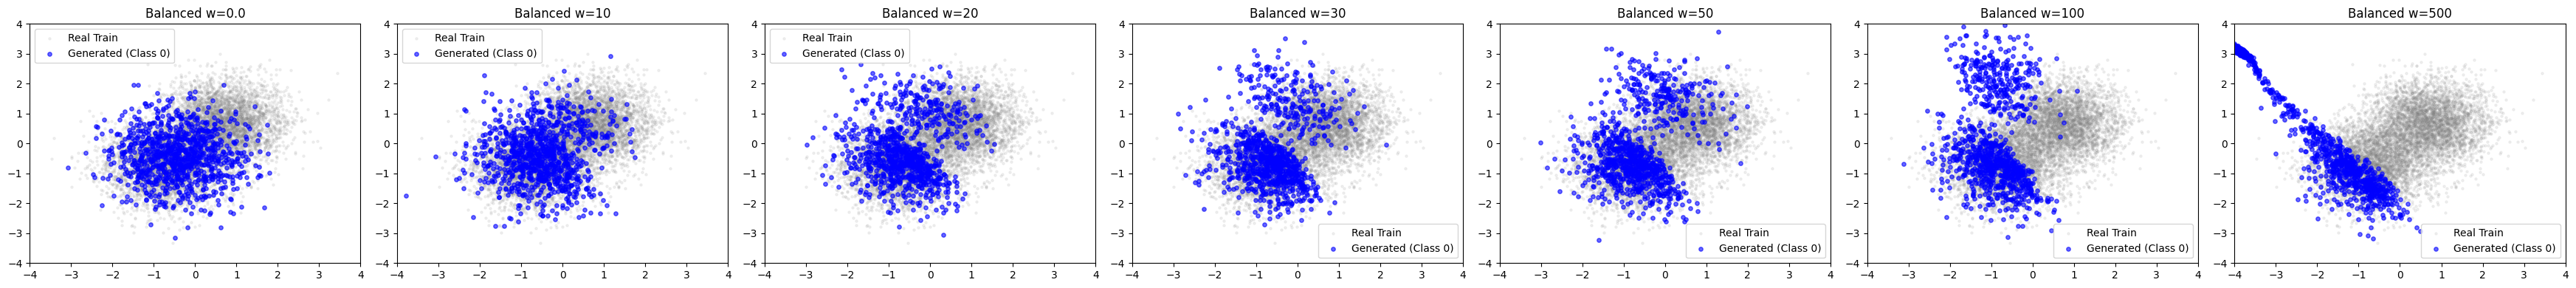

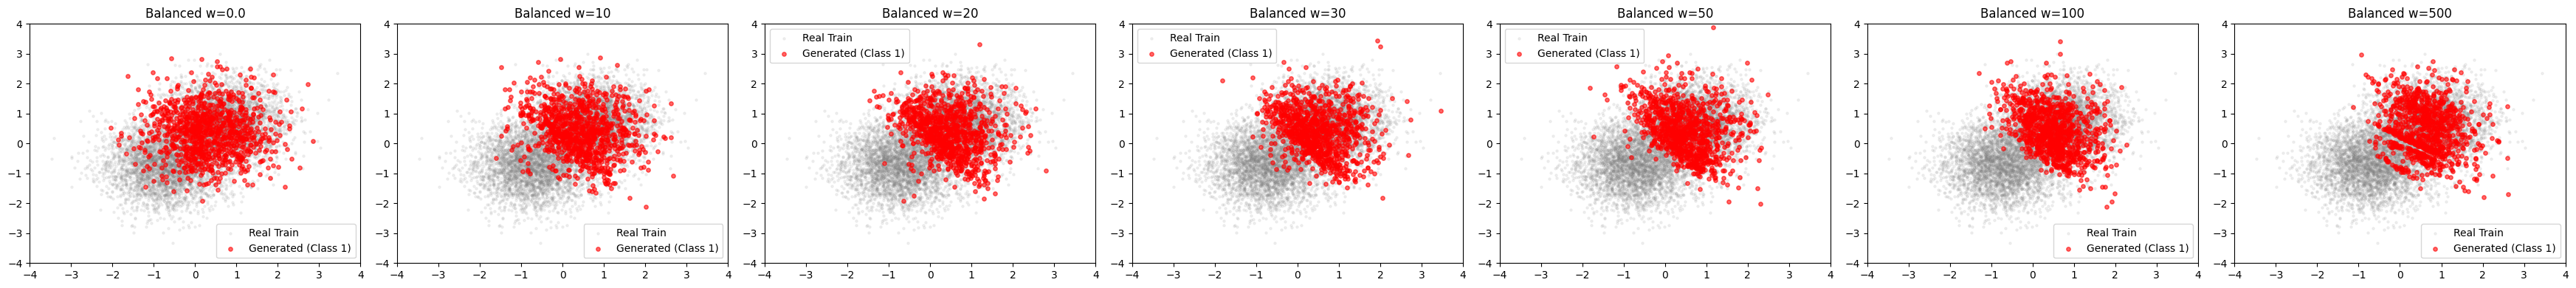

In [13]:
# --- Guidance Sweep ---
N_GEN_BAL = 1000
w_values_bal = [0.0, 10, 20, 30, 50, 100, 500]
print(f"Sampling {N_GEN_BAL} points per w (balanced)...")

def guidance_sweep(model, scheduler, classifier, G_cache, w_values, n_samples, target_class):
    samples_by_w = {}
    for w in w_values:
        samples_by_w[w] = tardiff_sample(model, scheduler, classifier, G_cache, n_samples=n_samples, target_class=target_class, w=w)
    return samples_by_w

samples_bal_0 = guidance_sweep(
    diff_model_bal,
    scheduler_bal,
    clf_bal,
    G_cache_bal,
    w_values=w_values_bal,
    n_samples=N_GEN_BAL,
    target_class=0
)

def plot_res_with_train(X_train_ref, samples, title, color, class_label, ax):
    ax.scatter(X_train_ref[:, 0].cpu(), X_train_ref[:, 1].cpu(), c='gray', s=5, alpha=0.1, label='Real Train')
    ax.scatter(samples[:, 0].cpu(), samples[:, 1].cpu(), c=color, s=15, alpha=0.6, label=f'Generated (Class {class_label})')
    ax.set_title(title)
    ax.legend()
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)

fig, axes = plt.subplots(1, len(w_values_bal), figsize=(5 * len(w_values_bal), 4))
if len(w_values_bal) == 1:
    axes = [axes]
for ax, w in zip(axes, w_values_bal):
    plot_res_with_train(X_train, samples_bal_0[w], f"Balanced w={w}", "blue", 0, ax)
plt.tight_layout()
plt.show()

samples_bal_1 = guidance_sweep(
    diff_model_bal,
    scheduler_bal,
    clf_bal,
    G_cache_bal,
    w_values=w_values_bal,
    n_samples=N_GEN_BAL,
    target_class=1
)

fig, axes = plt.subplots(1, len(w_values_bal), figsize=(5 * len(w_values_bal), 4))
if len(w_values_bal) == 1:
    axes = [axes]
for ax, w in zip(axes, w_values_bal):
    plot_res_with_train(X_train, samples_bal_1[w], f"Balanced w={w}", "red", 1, ax)
plt.tight_layout()
plt.show()

### 3.7 Utilité downstream (TSTR)

On mesure l'impact du guidage sur une tâche de classification entraînée sur les données synthétiques.

In [14]:
def tstr_evaluation_generic(X_train_ref, y_train_ref, X_test_ref, y_test_ref, syn_min_samples, name="", epochs=30):
    mask_0 = (y_train_ref == 0)
    X_maj_real = X_train_ref[mask_0]
    y_maj_real = y_train_ref[mask_0]
    
    X_syn_1 = syn_min_samples
    y_syn_1 = torch.ones(len(X_syn_1), dtype=torch.long).to(DEVICE)
    
    X_train_mix = torch.cat([X_maj_real, X_syn_1])
    y_train_mix = torch.cat([y_maj_real, y_syn_1])
    
    loader_mix = DataLoader(TensorDataset(X_train_mix, y_train_mix), batch_size=64, shuffle=True)
    
    new_clf = SimpleClassifier().to(DEVICE)
    train_classifier(new_clf, loader_mix, TrainConfig(clf_epochs=epochs))
    
    res = eval_classifier(new_clf, X_test_ref, y_test_ref)
    print(f"[{name}] TSTR Results: {res}")
    return res

In [15]:
# --- Downstream Utility (Balanced 50/50) ---
print("\n--- Downstream Utility (Balanced 50/50) ---")
results_bal = {}
for w, samples in samples_bal.items():
    results_bal[w] = tstr_evaluation_generic(
        X_train, y_train, X_test, y_test,
        samples,
        name=f"Balanced w={w}",
        epochs=30
    )
print("Summary (Balanced):", results_bal)


--- Downstream Utility (Balanced 50/50) ---


NameError: name 'samples_bal' is not defined

## 6. Cas déséquilibré (90/10)

On répète le pipeline sur un dataset **déséquilibré** pour analyser :
- l'impact de $w$ (guidance strength),
- l'impact downstream (TSTR),
- le choix du guidance set (tous / majorité / minorité).

### 6.1 Entraîner le classifieur downstream

In [ ]:
# --- Train downstream classifier ---
clf = SimpleClassifier().to(DEVICE)
train_classifier(clf, train_loader, cfg_train)
metrics_real = eval_classifier(clf, X_test, y_test)
print("Downstream on real:", metrics_real)

Downstream on real: {'acc': 0.997, 'auroc': 1.0, 'auprc': 1.0}


Maintenant, calculons le cache d'influence $G$ sur l'ensemble de validation :

In [ ]:
# --- Influence cache ---
G_cache = compute_influence_cache(clf, guide_loader)
print("Influence cache norms:", {k: float(v.norm().item()) for k, v in G_cache.items()})

Influence cache norms: {'net.0.weight': 0.2503291368484497, 'net.0.bias': 0.5904548764228821, 'net.2.weight': 0.6009871959686279, 'net.2.bias': 0.47698283195495605}


In [ ]:
# --- Helper: split guide set by class (imbalanced section) ---

def build_guide_loaders(X_guide, y_guide, batch_size=None):
    if batch_size is None:
        batch_size = len(X_guide)
    loader_all = DataLoader(TensorDataset(X_guide, y_guide), batch_size=batch_size, shuffle=False)
    mask_maj = (y_guide == 0)
    mask_min = (y_guide == 1)
    loader_maj = DataLoader(TensorDataset(X_guide[mask_maj], y_guide[mask_maj]), batch_size=max(1, len(X_guide[mask_maj])), shuffle=False)
    loader_min = DataLoader(TensorDataset(X_guide[mask_min], y_guide[mask_min]), batch_size=max(1, len(X_guide[mask_min])), shuffle=False)
    return loader_all, loader_maj, loader_min

In [ ]:
# --- Guidance set variants (imbalanced) ---
X_guide_all, y_guide_all = next(iter(guide_loader))

guide_all_loader, guide_maj_loader, guide_min_loader = build_guide_loaders(X_guide_all, y_guide_all)

G_cache_all = G_cache
G_cache_maj = compute_influence_cache(clf, guide_maj_loader)
G_cache_min = compute_influence_cache(clf, guide_min_loader)

print("Influence cache norms (all):", {k: float(v.norm().item()) for k, v in G_cache_all.items()})
print("Influence cache norms (major):", {k: float(v.norm().item()) for k, v in G_cache_maj.items()})
print("Influence cache norms (minor):", {k: float(v.norm().item()) for k, v in G_cache_min.items()})

Influence cache norms (all): {'net.0.weight': 0.2503291368484497, 'net.0.bias': 0.5904548764228821, 'net.2.weight': 0.6009871959686279, 'net.2.bias': 0.47698283195495605}
Influence cache norms (major): {'net.0.weight': 0.14973191916942596, 'net.0.bias': 0.5949037075042725, 'net.2.weight': 0.6308627724647522, 'net.2.bias': 0.4750601053237915}
Influence cache norms (minor): {'net.0.weight': 0.1477069854736328, 'net.0.bias': 0.5966217517852783, 'net.2.weight': 0.6267651319503784, 'net.2.bias': 0.4789474308490753}


#### 6.1.1 Variantes de guidance set (All / Majority / Minority)

On isole le guidance set selon la classe pour analyser comment le cache d'influence $G$ change et comment cela affecte la génération.

Enfin, entraînons le modèle de diffusion :

In [ ]:
# --- Diffusion training ---
diff_model = SimpleDiffusionNet().to(DEVICE)
train_diffusion(diff_model, train_loader, scheduler, cfg_train)
print("Diffusion trained.")

Diffusion trained.


### 6.2 Sanity check: Fidélité distributionnelle (w=0)

Avant d'appliquer TarDiff, il est crucial de vérifier que notre modèle DDPM de base (sans guidage, $w=0$) a bien appris la distribution conditionnelle $p(x|y)$.
Nous comparons ici les données réelles et les données générées via :
1.  **Marginales** : Histogrammes par dimension.
2.  **Moments** : Moyenne et écart-type par classe.
3.  **Scatter plot complet** : Visualisation globale des deux classes.

Generating validation samples...
--- Check Distribution: Class 0 (Majoritaire) ---
Diff Mean (L2): 0.4067
Diff Std  (L2): 0.0941
Wasserstein Dist | Dim0: 0.2898, Dim1: 0.2856
--- Check Distribution: Class 1 (Minoritaire) ---
Diff Mean (L2): 0.4683
Diff Std  (L2): 0.0973
Wasserstein Dist | Dim0: 0.3450, Dim1: 0.3173


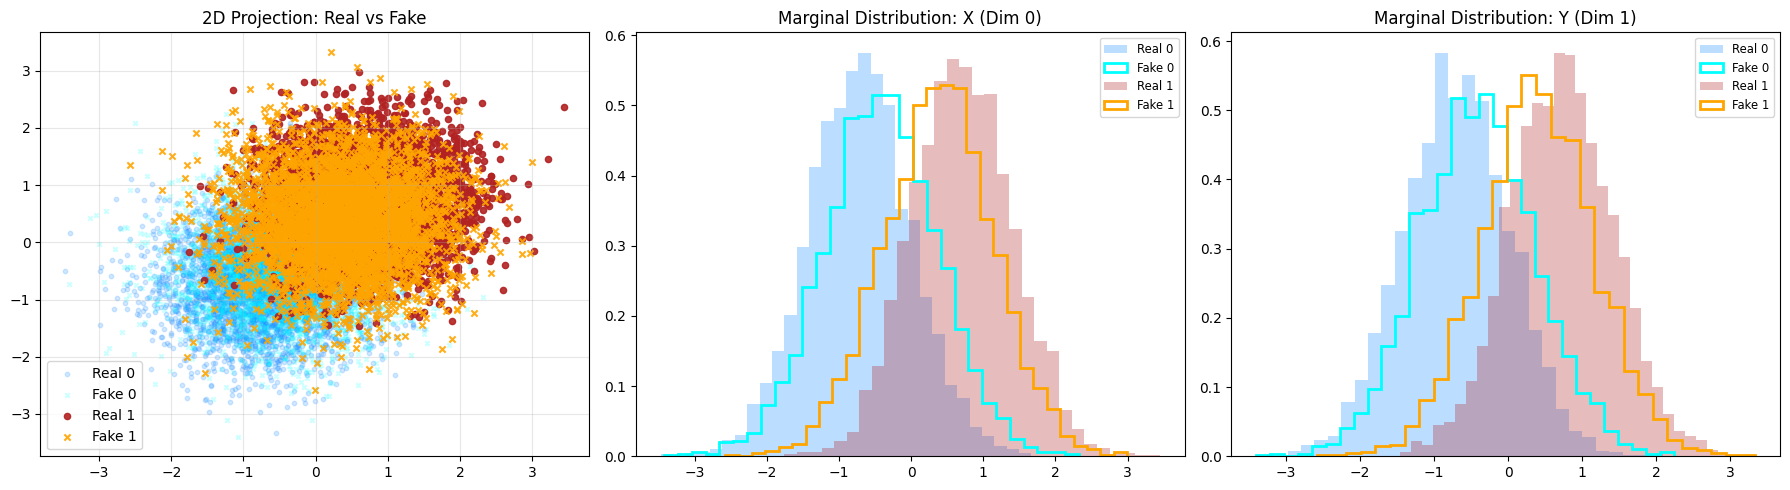

In [ ]:
# --- Run Validation & Plots ---

print("Generating validation samples...")
# On valide séparément les deux classes pour voir si le conditionnement marche
X_maj_real = X_train[y_train==0]
X_maj_gen = sample_standard(diff_model, scheduler, len(X_maj_real), 0)

X_min_real = X_train[y_train==1]
X_min_gen = sample_standard(diff_model, scheduler, len(X_min_real), 1)

# Metrics
check_distribution_metrics(X_maj_real, X_maj_gen, "Class 0 (Majoritaire)")
check_distribution_metrics(X_min_real, X_min_gen, "Class 1 (Minoritaire)")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter Plot Overlay
axes[0].set_title("2D Projection: Real vs Fake")
axes[0].scatter(X_maj_real[:,0].cpu(), X_maj_real[:,1].cpu(), alpha=0.2, label="Real 0", c='dodgerblue', s=10)
axes[0].scatter(X_maj_gen[:,0].cpu(), X_maj_gen[:,1].cpu(), alpha=0.2, label="Fake 0", c='cyan', s=10, marker='x')
axes[0].scatter(X_min_real[:,0].cpu(), X_min_real[:,1].cpu(), alpha=0.9, label="Real 1", c='firebrick', s=20)
axes[0].scatter(X_min_gen[:,0].cpu(), X_min_gen[:,1].cpu(), alpha=0.9, label="Fake 1", c='orange', s=20, marker='x')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distributions Marginales
for dim, ax, name in zip([0, 1], axes[1:], ["X (Dim 0)", "Y (Dim 1)"]):
    ax.set_title(f"Marginal Distribution: {name}")
    # Real 0
    ax.hist(X_maj_real[:, dim].cpu().numpy(), bins=30, density=True, alpha=0.3, color='dodgerblue', label='Real 0')
    # Fake 0
    ax.hist(X_maj_gen[:, dim].cpu().numpy(), bins=30, density=True, histtype='step', linewidth=2, color='cyan', label='Fake 0')
    # Real 1
    ax.hist(X_min_real[:, dim].cpu().numpy(), bins=30, density=True, alpha=0.3, color='firebrick', label='Real 1')
    # Fake 1
    ax.hist(X_min_gen[:, dim].cpu().numpy(), bins=30, density=True, histtype='step', linewidth=2, color='orange', label='Fake 1')
    ax.legend(fontsize='small')

plt.tight_layout()
plt.show()

On voit que la classe majoritaire est bien capturée, tandis que la classe minoritaire est bien moins synthétisée, ce qui est attendu vu son faible effectif dans les données d'entraînement. En effet, la loss de diffusion est dominée par la classe majoritaire, ce qui conduit le modèle à privilégier cette région de l'espace.

### 6.3 Résultats principaux : TarDiff Sampling

- On génère des samples pour la classe minoritaire ($y=1$)
- **Baseline** : diffusion standard ($w=0$).
- **TarDiff** : diffusion guidée avec influence ($w=10$ ou plus).
- On visualise les points générés par rapport à la distribution réelle et à la frontière de décision.

In [ ]:
# --- Génération (imbalanced 90/10) ---
N_GEN = 100
w_values = [0.0, 10.0, 20, 50, 100, 500]
print(f"Sampling {N_GEN} points per w (imbalanced)...")

samples_by_w = guidance_sweep(
    diff_model,
    scheduler,
    clf,
    G_cache_all,
    w_values=w_values,
    n_samples=N_GEN,
    target_class=1
)

w_choice = 10.0
samples_by_guidance = {
    "All": tardiff_sample(diff_model, scheduler, clf, G_cache_all, n_samples=N_GEN, target_class=1, w=w_choice),
    "Majority": tardiff_sample(diff_model, scheduler, clf, G_cache_maj, n_samples=N_GEN, target_class=1, w=w_choice),
    "Minority": tardiff_sample(diff_model, scheduler, clf, G_cache_min, n_samples=N_GEN, target_class=1, w=w_choice)
}

print("Sampling done (imbalanced).")

Sampling 100 points per w (imbalanced)...
Sampling done (imbalanced).
Sampling done (imbalanced).


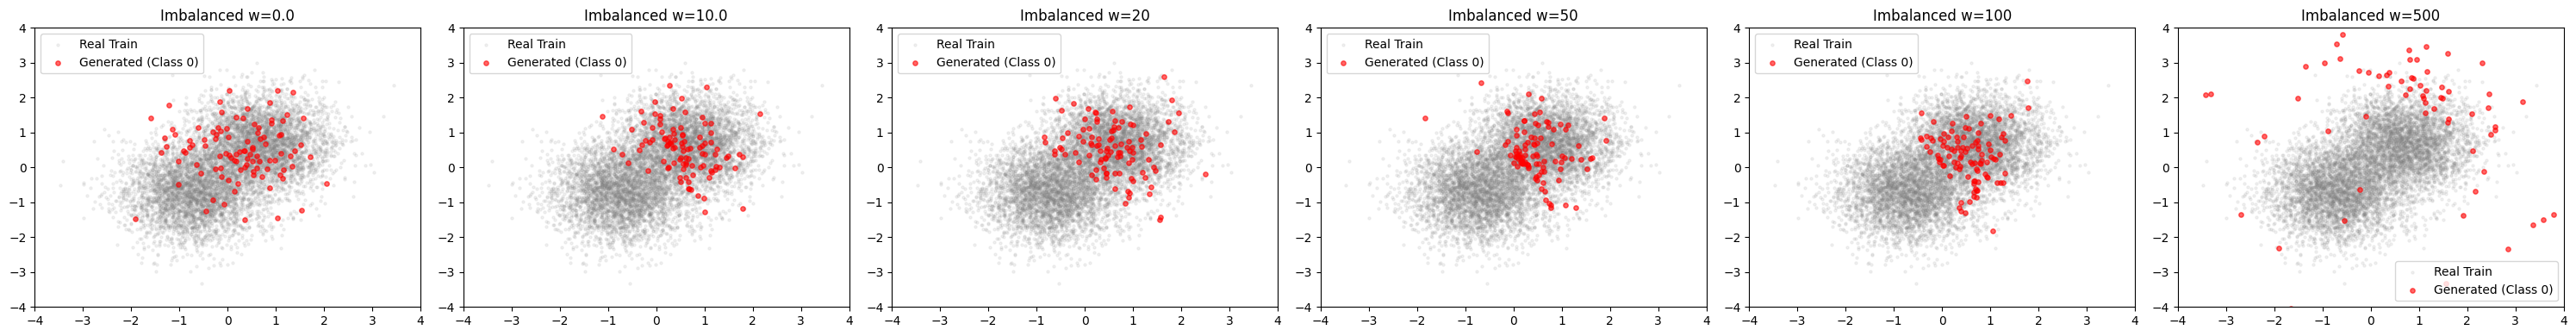

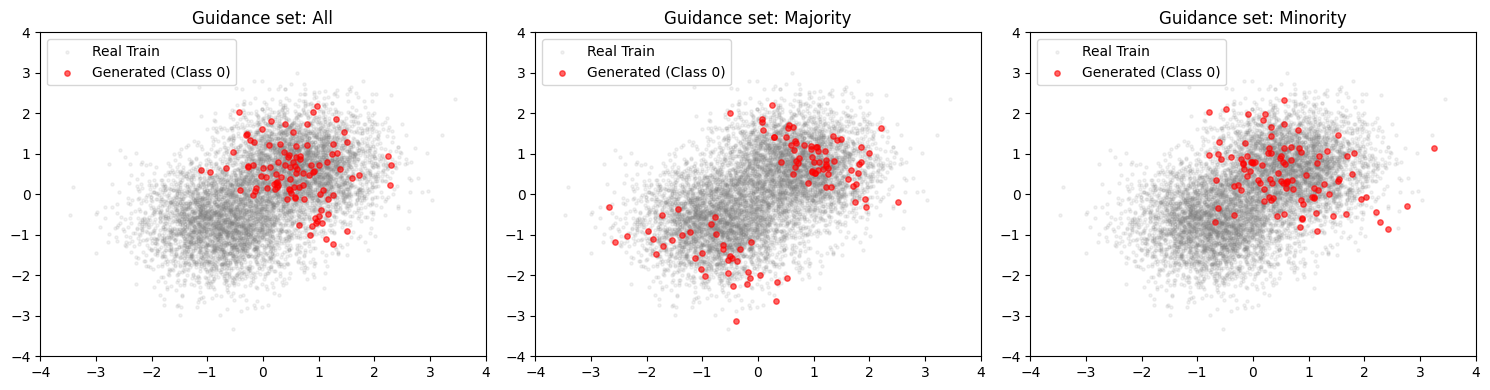

In [ ]:
# --- Visualization (imbalanced) ---
fig, axes = plt.subplots(1, len(w_values), figsize=(5 * len(w_values), 4))
if len(w_values) == 1:
    axes = [axes]
for ax, w in zip(axes, w_values):
    plot_res_with_train(X_train, samples_by_w[w], f"Imbalanced w={w}", 0, ax)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, samples) in zip(axes, samples_by_guidance.items()):
    plot_res_with_train(X_train, samples, f"Guidance set: {name}", 0, ax)
plt.tight_layout()
plt.show()

Computing per-sample gradient norms on Guide Set...
Mean Norm Major (Class 0): 0.3779 +/- 0.7818
Mean Norm Minor (Class 1): 0.4514 +/- 0.8000
Mean Norm Major (Class 0): 0.3779 +/- 0.7818
Mean Norm Minor (Class 1): 0.4514 +/- 0.8000


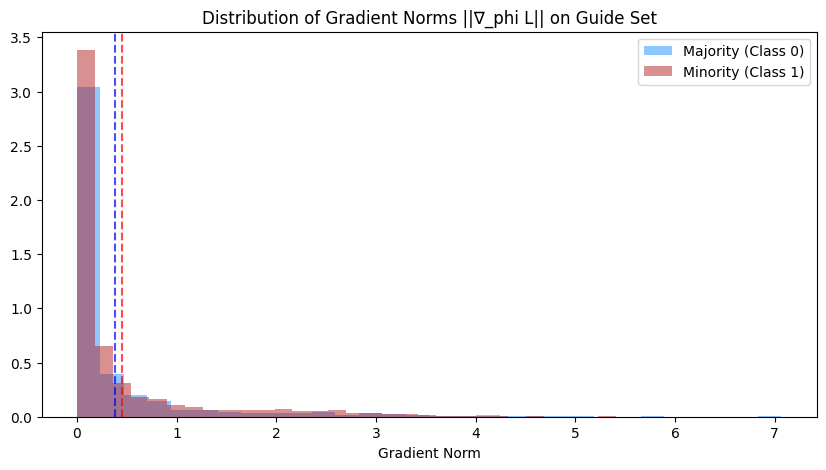

In [ ]:
# --- Gradient Norm Analysis ---

def analyze_gradient_norms(classifier, loader):
    classifier.eval()
    criterion = nn.CrossEntropyLoss()
    
    norms_maj = []
    norms_min = []
    
    print("Computing per-sample gradient norms on Guide Set...")
    
    # On récupère toutes les données
    all_X, all_y = [], []
    for x, y in loader:
        all_X.append(x)
        all_y.append(y)
    
    if not all_X: return [], []
    
    X_all = torch.cat(all_X)
    y_all = torch.cat(all_y)
    
    # Boucle sample par sample
    with torch.set_grad_enabled(True):
        for i in range(len(X_all)):
            x_i = X_all[i:i+1].to(DEVICE)
            y_i = y_all[i:i+1].to(DEVICE)
            
            output = classifier(x_i)
            loss = criterion(output, y_i)
            
            grads = torch.autograd.grad(loss, classifier.parameters())
            
            # Norme L2 concaténée
            total_norm_sq = 0.0
            for g in grads:
                total_norm_sq += g.norm(2).item() ** 2
            total_norm = math.sqrt(total_norm_sq)
            
            if y_i.item() == 0:
                norms_maj.append(total_norm)
            else:
                norms_min.append(total_norm)
                
    return np.array(norms_maj), np.array(norms_min)

norms_maj, norms_min = analyze_gradient_norms(clf, guide_loader)

print(f"Mean Norm Major (Class 0): {norms_maj.mean():.4f} +/- {norms_maj.std():.4f}")
print(f"Mean Norm Minor (Class 1): {norms_min.mean():.4f} +/- {norms_min.std():.4f}")

# Visualization
plt.figure(figsize=(10, 5))
plt.hist(norms_maj, bins=30, alpha=0.5, label=f'Majority (Class 0)', density=True, color='dodgerblue')
plt.hist(norms_min, bins=30, alpha=0.5, label=f'Minority (Class 1)', density=True, color='firebrick')
plt.axvline(norms_maj.mean(), color='blue', linestyle='--', alpha=0.7)
plt.axvline(norms_min.mean(), color='red', linestyle='--', alpha=0.7)
plt.title("Distribution of Gradient Norms ||∇_phi L|| on Guide Set")
plt.xlabel("Gradient Norm")
plt.legend()
plt.show()

### 6.4 Utilité Downstream (Train on Synthetic, Test on Real)

On entraîne un **nouveau classifieur** uniquement sur les données synthétiques générées (augmentées ou remplacées) et on teste sur le vrai test set.
Ici, on remplace la classe minoritaire par des données synthétiques.

- **Expérience** : Class 0 (Réel) + Class 1 (Synthétique).
- **Comparaison** : impact de $w$ et du guidance set (all/major/minor).

In [ ]:
print("\n--- Downstream Utility Evaluation (Imbalanced 90/10) ---")

results_w_imb = {}
for w, samples in samples_by_w.items():
    results_w_imb[w] = tstr_evaluation_generic(
        X_train, y_train, X_test, y_test,
        samples,
        name=f"Imbalanced w={w}",
        epochs=30
    )

results_guidance_imb = {}
for name, samples in samples_by_guidance.items():
    results_guidance_imb[name] = tstr_evaluation_generic(
        X_train, y_train, X_test, y_test,
        samples,
        name=f"Imbalanced guidance={name}",
        epochs=30
    )

print("Summary (Imbalanced - w sweep):", results_w_imb)
print("Summary (Imbalanced - guidance):", results_guidance_imb)


--- Downstream Utility Evaluation (Imbalanced 90/10) ---
[Imbalanced w=0.0] TSTR Results: {'acc': 0.5, 'auroc': 1.0, 'auprc': 1.0}
[Imbalanced w=0.0] TSTR Results: {'acc': 0.5, 'auroc': 1.0, 'auprc': 1.0}
[Imbalanced w=10.0] TSTR Results: {'acc': 0.8695, 'auroc': 1.0, 'auprc': 1.0}
[Imbalanced w=10.0] TSTR Results: {'acc': 0.8695, 'auroc': 1.0, 'auprc': 1.0}
[Imbalanced w=20] TSTR Results: {'acc': 0.933, 'auroc': 1.0, 'auprc': 1.0}
[Imbalanced w=20] TSTR Results: {'acc': 0.933, 'auroc': 1.0, 'auprc': 1.0}
[Imbalanced w=50] TSTR Results: {'acc': 0.93, 'auroc': 1.0, 'auprc': 1.0}
[Imbalanced w=50] TSTR Results: {'acc': 0.93, 'auroc': 1.0, 'auprc': 1.0}
[Imbalanced w=100] TSTR Results: {'acc': 0.932, 'auroc': 1.0, 'auprc': 1.0}
[Imbalanced w=100] TSTR Results: {'acc': 0.932, 'auroc': 1.0, 'auprc': 1.0}
[Imbalanced w=500] TSTR Results: {'acc': 0.51, 'auroc': 1.0, 'auprc': 1.0}
[Imbalanced w=500] TSTR Results: {'acc': 0.51, 'auroc': 1.0, 'auprc': 1.0}
[Imbalanced guidance=All] TSTR Results

## 7. Discussion et Conclusion

### Discussion

1. **Balanced (50/50)** : Le DDPM capture bien la distribution et la guidance $w$ montre un compromis clair entre diversité et utilité downstream.
2. **Imbalanced (90/10)** : La diffusion standard favorise la classe majoritaire. TarDiff aide la minorité, mais un $w$ trop fort entraîne du collapse.
3. **Guidance alignée papier** : La guidance utilise désormais le signe négatif dans $G$ (réduction de loss), et le score d'influence reste un produit scalaire $\nabla_\phi \ell(x,y)\cdot G$ comme en Eq.(23), sans inversion manuelle de $w$.
4. **Choix du guidance set** : Un guidance set centré sur la minorité augmente l'impact des gradients de classe rare, mais peut accentuer le sur-guidage. Un guidance set mixte reste le plus stable.

### Conclusion

Nous avons implémenté **TarDiff** sur un problème jouet complet.
- **Formulation** : Guidage orienté par un gradient d'influence.
- **Code** : Pipeline complet PyTorch (Data, Model, Diff, Influence, Sampling).
- **Résultats** : Confirmation que le guidage par influence permet de manipuler la génération pour favoriser une tâche cible, au-delà de la simple fidélité.

**Next steps possibles** :
- Appliquer sur des séries temporelles réelles (EHR) avec un backbone (i.e. Transformer/RNN).
- Explorer des métriques de diversité pour quantifier formellement le trade-off.
- Tester sur un cas où le shift distributionnel (train vs test) est plus marqué.